# Breast-Ultrasound-Segmentation

## About Dataset
Breast cancer is one of the most common causes of death among women worldwide. Early detection helps in reducing the number of early deaths. The data reviews the medical images of breast cancer using ultrasound scan. Breast Ultrasound Dataset is categorized into three classes: normal, benign, and malignant images. Breast ultrasound images can produce great results in classification, detection, and segmentation of breast cancer when combined with machine learning.

### Data
The data collected at baseline include breast ultrasound images among women in ages between 25 and 75 years old. This data was collected in 2018. The number of patients is 600 female patients. The dataset consists of 780 images with an average image size of 500*500 pixels. The images are in PNG format. The ground truth images are presented with original images. The images are categorized into three classes, which are normal, benign, and malignant.

If you use this dataset, please cite:
Al-Dhabyani W, Gomaa M, Khaled H, Fahmy A. Dataset of breast ultrasound images. Data in Brief. 2020 Feb;28:104863. DOI: 10.1016/j.dib.2019.104863.

## Imports

In [1]:
import os

import pyrootutils

root = pyrootutils.setup_root(
    search_from=os.path.dirname(os.getcwd()),
    indicator=[".git", "pyproject.toml"],
    pythonpath=True,
    dotenv=True,
)

if os.getenv("DATA_ROOT") is None:
    os.environ["DATA_ROOT"] = f"{root}/data"

In [2]:
import torch

# Setup device-agnostic code
if torch.cuda.is_available():
    DEVICE = "cuda"  # NVIDIA GPU
    print("GPU Found!!")
else:
    raise Exception("No GPU Found!!")

GPU Found!!


In [3]:
import cv2
import hydra
import numpy as np
import opendatasets as od
from hydra import compose, initialize
from omegaconf import OmegaConf
from tqdm.notebook import tqdm

In [4]:
# # auto reload dotenv
%load_ext dotenv
%dotenv

# auto reload libs
%load_ext autoreload
%autoreload 2

## Paths setup

In [5]:
from omegaconf import DictConfig

with initialize(config_path="../configs", job_name="EDA", version_base=None):
    cfg: DictConfig = compose(config_name="train.yaml")
    # print(OmegaConf.to_yaml(cfg))
    print(cfg.paths)

{'root_dir': '${oc.env:PROJECT_ROOT}', 'root_data_dir': '${oc.env:DATA_ROOT}', 'log_dir': '${paths.root_dir}/logs/', 'output_dir': '${hydra:runtime.output_dir}', 'work_dir': '${hydra:runtime.cwd}'}


In [11]:
from pathlib import Path

ROOT_DIR = Path(cfg.paths.root_dir)
ROOT_DATA_DIR = Path(cfg.paths.root_data_dir)
DATASET_URL = cfg.data.url
DATA_DIR = ROOT_DATA_DIR / Path(cfg.data.dataset_dir)
DATA_DIR

PosixPath('/workspaces/PyTorch-Breast-Ultrasound-Segmentation/data/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT')

## Download Datasets

In [12]:
if len(list(ROOT_DATA_DIR.iterdir())) == 0:
    print("Downloading dataset from kaggle...")
    od.download(dataset_id_or_url=DATASET_URL, data_dir=str(ROOT_DATA_DIR))

## Data Loading

In [13]:
import matplotlib.pyplot as plt
from torchvision.io import read_image

In [17]:
image = read_image(str(DATA_DIR / "benign/benign (1).png"))
mask = read_image(str(DATA_DIR / "benign/benign (1)_mask.png"))
image.shape

torch.Size([3, 471, 562])

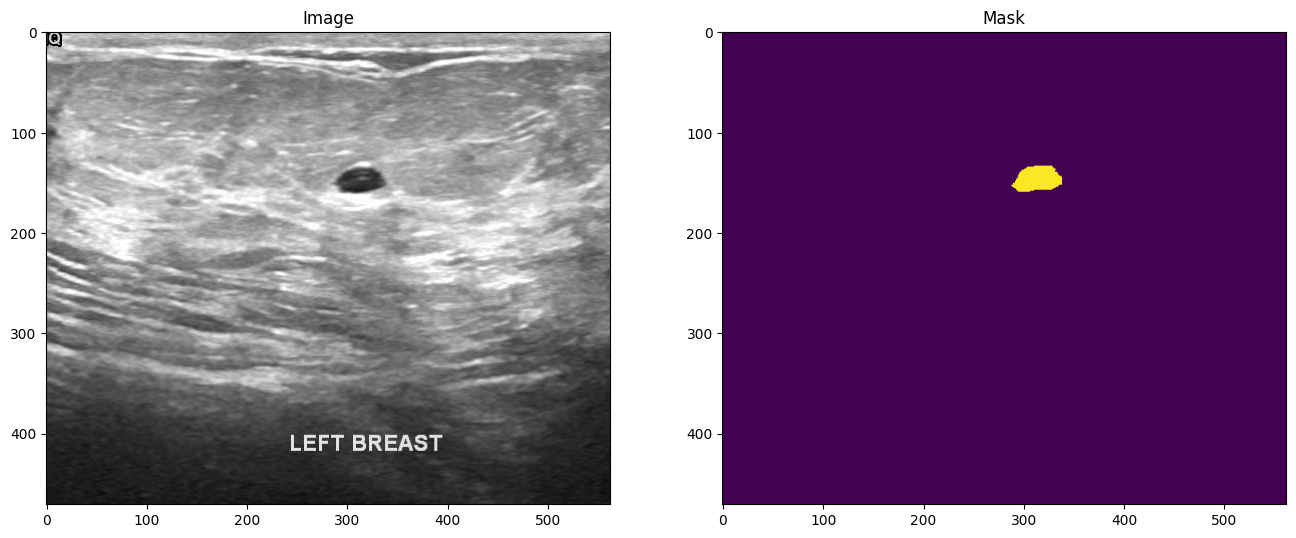

In [16]:
image = read_image(str(DATA_DIR / "benign/benign (1).png"))
mask = read_image(str(DATA_DIR / "benign/benign (1)_mask.png"))
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

## Dataloader